In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import pandas as pd
import healpy as hp
from scipy.stats import binned_statistic
import rubin_sim.maf as maf
from rubin_sim.data import get_baseline
import time
import sys
import sqlite3
import json
import glob
from natsort import natsorted

In [2]:
# taken from Peter and Lynne's original notebooks
# https://github.com/rhiannonlynne/notebooks/blob/master/Template%20Generation.ipynb
# https://github.com/yoachim/22_Scratch/blob/main/template_metrics/template_stuff.ipynb

# get just the first year of observations

In [3]:
baseline_db = "baseline_v3.0_10yrs.db"
year1_fname = 'first_year_{}.db'.format(baseline_db.split(".db")[0])

# nside = 256
nside = 32

# save_dir = "remove_no_template_results_{}".format(nside)
save_dir = "remove_no_template_results_{}_noDD".format(nside)
# save_dir = "/Volumes/Nargothrond/rubin_templates/remove_no_template_results_{}_noDD".format(nside)

In [4]:
opsim_fname = year1_fname
opsim_fname

'first_year_baseline_v3.0_10yrs.db'

In [5]:
# opsdb = maf.OpsimDatabase(opsim_fname)
opsdb = opsim_fname
runName = os.path.split(opsdb)[-1].replace('.db', '')
opsdb,runName

('first_year_baseline_v3.0_10yrs.db', 'first_year_baseline_v3.0_10yrs')

In [6]:
# range of nights to investigate (year 1 of survey)
night_min = 0
night_max = 365

# template generation timescales to test
# tscales = [28,28*4,28*6]
# tscales = [1,3,7,14,28,28*4,28*6]
# tscales = [3,7,14,28,28*4,28*6]
# tscales = [7,14,28]
tscales = [28]

# store the timescale and template generation nights in a dict
template_timescales = {}

for tscale in tscales:
    
    # divide year 1 into chunks of a given template_timescale
    template_nights = np.arange(0,night_max+tscale,tscale)
    template_nights[-1] = night_max # consider only the first year
        
    template_timescales[str(tscale)] = template_nights
    
template_timescales

{'28': array([  0,  28,  56,  84, 112, 140, 168, 196, 224, 252, 280, 308, 336,
        364, 365])}

In [7]:
if not os.path.isfile(year1_fname): 
    print("get year 1 observations")
    conn = sqlite3.connect(baseline_db)
    df = pd.read_sql('select * from observations;', conn)
    df_year1 = df[df["night"]<night_max]
    conn.close()

    # open up a connection to a new database
    conn = sqlite3.connect(year1_fname)
    df_year1.to_sql('observations', conn, index=False, if_exists='replace')
    conn.close()
    
else:
    conn = sqlite3.connect(year1_fname)
    df_year1 = pd.read_sql('select * from observations;', conn)
    conn.close()

# Load the saved template metric data and combine the chunks

In [8]:
def load_template_metric(runName,
                         metric="doAllTemplateMetrics_Count",
                         slicer = "HEAL",
                         filt="all",save_dir="remove_no_template_results_32",
                         time = False,
                         operation="sum",
                        print_flag=False):
    
    """
    The doAllTemplateMetrics works by running metrics on batches of observations made between nights on which templates were generated.
    This function loads the all the files of a previously run metric.
    An operation can be performed on all of these reloaded metrics,
    e.g. the total number of visits from the "Count" metric can be found by using "sum".
    
    time allows you to select a single metric file for some time batch
    
    The save_dir is searched for files matching some pattern: runName, metric, filt, slicer
    """
        
    # glob all files in the save_dir
    files = glob.glob("{}/*npz".format(save_dir))
    
    # select the relevant metric files using the patterns
    if filt=="all": # select all filters
        _files = [x for x in files if (runName in x) 
                 & (metric in x)
                 & (slicer in x)
                 & ~(("_u_".format(filt) in x)
                 | ("_g_".format(filt) in x)
                 | ("_r_".format(filt) in x)
                 | ("_i_".format(filt) in x)
                 | ("_z_".format(filt) in x)
                 | ("_y_".format(filt) in x))
                 ]
    elif "_or_" in filt:
        _files = [x for x in files if (runName in x) 
                  & (metric in x) 
                  & (slicer in x)
                  & ("_{}_".format(filt) in x)
                  & ("_or_" in x)]
    else:
        _files = [x for x in files if (runName in x) 
                  & (metric in x) 
                  & (slicer in x)
                  & ("_{}_".format(filt) in x)
                  & ("_or_" not in x)]
            
    if time: # trim down based on a specific timestamp
        _files = [x for x in _files if ("_lt_{}_".format(str(time)) in x)]        
        
    _files = natsorted(_files) # ensure files are in numerical order (based on the template generation night considered)
    if print_flag:
        print(_files)
    print(len(_files))
    
    if len(_files)==0:
        # there are no files
        print("no files")
        return

    # load all these metric files
    metric_bundle = []
    for x in _files:
        metric_bundle.append(maf.MetricBundle.load(x))

    # retrieve data/mask for all the masked arrays
    # each value in data corresponds to the metric value for some slice point
    data = [mb.metric_values.data for mb in metric_bundle]
    mask = [mb.metric_values.mask for mb in metric_bundle]
    metric_data = np.ma.array(data, mask=mask)

    if operation == "min":
        # find the minimum of all constituent metrics
        metric_vals = metric_data.min(axis=0)
    elif operation == "sum":
        # find the sum of all constituent metrics
        ### Sum of just one file should produce just the file?
        metric_vals = metric_data.sum(axis=0)
    ### Add a new operation for DeltaNight and NTemplate
#     elif operation == "first":
#         # take the first not badval value
    else:
        # return the untouched multidimensional masked array if you want to look at it separately
        print("no operation performed")
        metric_vals = metric_data
    
    print(metric_vals,len(metric_vals))
    
    # replace the masked values with nan
    metric_vals.fill_value = np.nan
    
    return metric_vals

In [9]:
def skymap_plot_Night(metric_plot, title, 
                      template_nights,
                      _min=None, _max=None):

    #plot the skymap
    x = hp.mollview(metric_plot, title=title, 
                    min = _min, max=_max,
                    cbar = None)
    hp.graticule()

    # customise the colorbar
    fig = plt.gcf()
    ax = plt.gca()
    image = ax.get_images()[0]
    # cbar = fig.colorbar(image, ax=ax, orientation = "horizontal",aspect = 30, location = "bottom")
    cbar = fig.colorbar(image, ax=ax, orientation = "horizontal", shrink = 0.5, location = "bottom",
                       pad = 0.05)

#     # fix the ticks at 0 nights and at the end?
#     ticks = template_nights[:-1]
#     cbar.set_ticks(ticks)
#     cbar.set_ticklabels(ticks)
    
    # set vmin, vmax to get constant scale for comparision?

#     fname = "{}.png".format("".join(title.split(" ")))
#     plt.savefig(fname, facecolor="w", transparent=True, bbox_inches="tight")
    
    plt.show()

In [10]:
# load individual template dates
# count the number of unique visits with templates

In [11]:
def skymap_plot(metric_plot, title):

    #plot the skymap
    x = hp.mollview(metric_plot, title=title, 
                    cbar = None)
    hp.graticule()

    # customise the colorbar
    fig = plt.gcf()
    ax = plt.gca()
    image = ax.get_images()[0]
    # cbar = fig.colorbar(image, ax=ax, orientation = "horizontal",aspect = 30, location = "bottom")
    cbar = fig.colorbar(image, ax=ax, orientation = "horizontal", shrink = 0.5, location = "bottom",
                       pad = 0.05)

#     fname = "{}.png".format("".join(title.split(" ")))
#     plt.savefig(fname, facecolor="w", transparent=True, bbox_inches="tight")

    plt.show()

In [12]:
def histogram_plot(metric_plot,bins="auto",title="hist_plot",pix_area=None):
    
    fig = plt.figure()
    gs = gridspec.GridSpec(1,1)
    ax1 = plt.subplot(gs[0,0])

    n,b,p = ax1.hist(metric_plot, bins = bins, histtype = "step")

    # ax1.axvline(np.median(data),c="C{}".format(i))

    # total area
    print(sum(n)*pix_area)

    
    ### CONVERT UNITS OR SCALE AXIS?
    if pix_area:
        # scale the y axis to get sky area
        y_vals = ax1.get_yticks()
        ax1.set_yticklabels(['{:3.0f}'.format(x * pix_area) for x in y_vals])
        ax1.set_ylabel("area (square degrees)")
    else:
        ax1.set_ylabel("number of healpixels")

    ax1.set_xlabel("metric number")

    plt.title("{} {}".format(_runName,m))

    plt.show()

In [13]:
# plot the results of the default baseline simulation

### TODO
# MAKE SURE AN OPERATION IS NOT PERFORMED HERE
# if len(_files)==1 return just the metric?
# Could be fine as the sum over a len 1 array is unchanged

# for m in ["CountMetric","PairMetric"]:
#     filt = "all"
#     pix_area = hp.pixelfunc.nside2pixarea(nside, degrees=True) # square degrees

#     _runName = "{}_nside-{}".format(runName,nside).replace(".","_")
#     print(_runName,m,filt)
#     metric_plot = load_template_metric(_runName,
#                                        metric=m,
#                                        filt=filt, print_flag=True,
#                                       save_dir = save_dir)
#     print(metric_plot.shape)

#     title = "{} {}".format(_runName,m)
#     skymap_plot(metric_plot, title = title)
#     histogram_plot(metric_plot,bins = 200,title=title,pix_area=pix_area)

first_year_baseline_v3_0_10yrs_nside-32 CountMetric all
['remove_no_template_results_32_noDD/first_year_baseline_v3_0_10yrs_nside-32_CountMetric_night_lt_365_and_note_not_like_DD_HEAL.npz']
1
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
[-- -- -- ... 30.0 25.0 24.0] 12288
(12288,)


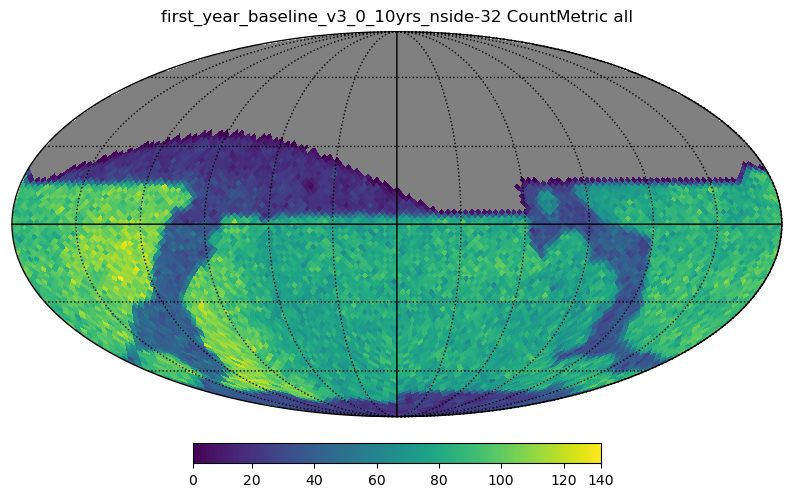

27998.836004244524


/tmp/ipykernel_84095/2638790992.py:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_yticklabels(['{:3.0f}'.format(x * pix_area) for x in y_vals])


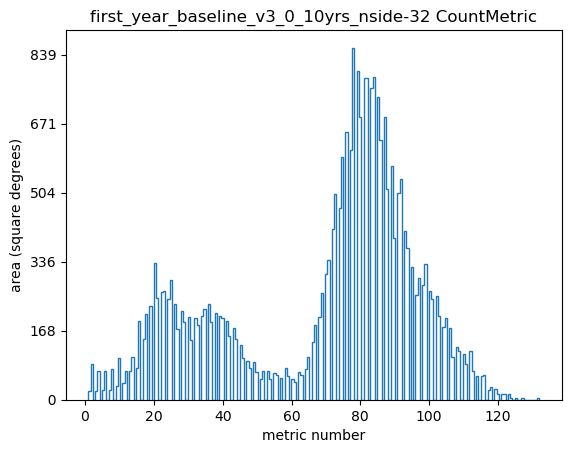

first_year_baseline_v3_0_10yrs_nside-32 CountMetric u
['remove_no_template_results_32_noDD/first_year_baseline_v3_0_10yrs_nside-32_CountMetric_u_and_night_lt_365_and_note_not_like_DD_HEAL.npz']
1
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
[-- -- -- ... 4.0 2.0 1.0] 12288
(12288,)


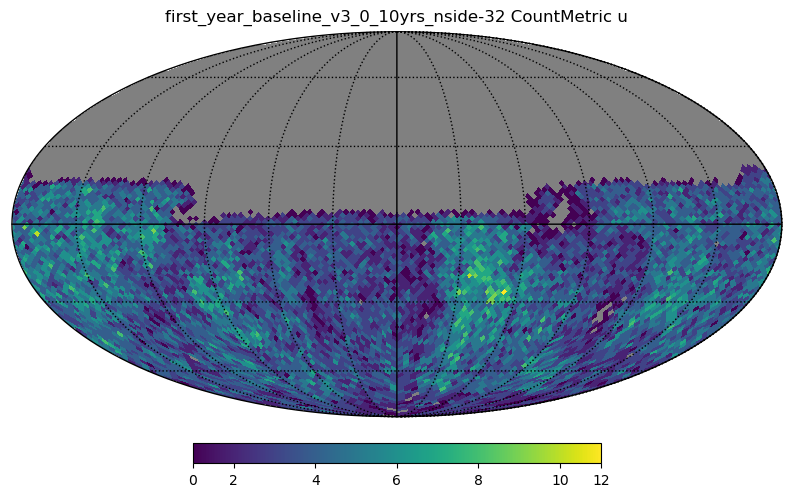

24446.945297710867


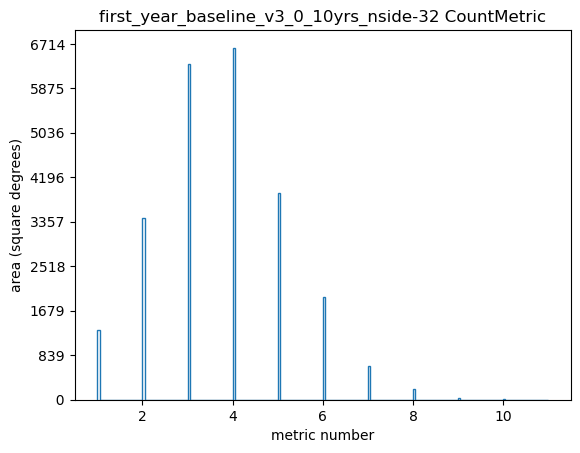

first_year_baseline_v3_0_10yrs_nside-32 CountMetric g
['remove_no_template_results_32_noDD/first_year_baseline_v3_0_10yrs_nside-32_CountMetric_g_and_night_lt_365_and_note_not_like_DD_HEAL.npz']
1
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
[-- -- -- ... 3.0 2.0 2.0] 12288
(12288,)


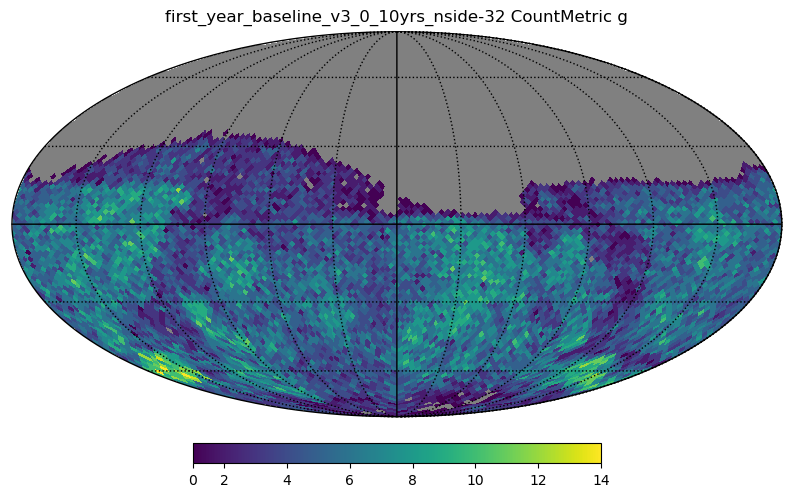

27485.18829337529


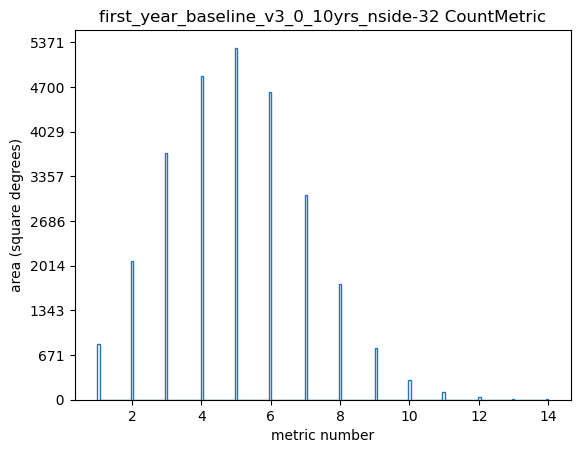

first_year_baseline_v3_0_10yrs_nside-32 CountMetric r
['remove_no_template_results_32_noDD/first_year_baseline_v3_0_10yrs_nside-32_CountMetric_r_and_night_lt_365_and_note_not_like_DD_HEAL.npz']
1
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
[-- -- -- ... 4.0 4.0 5.0] 12288
(12288,)


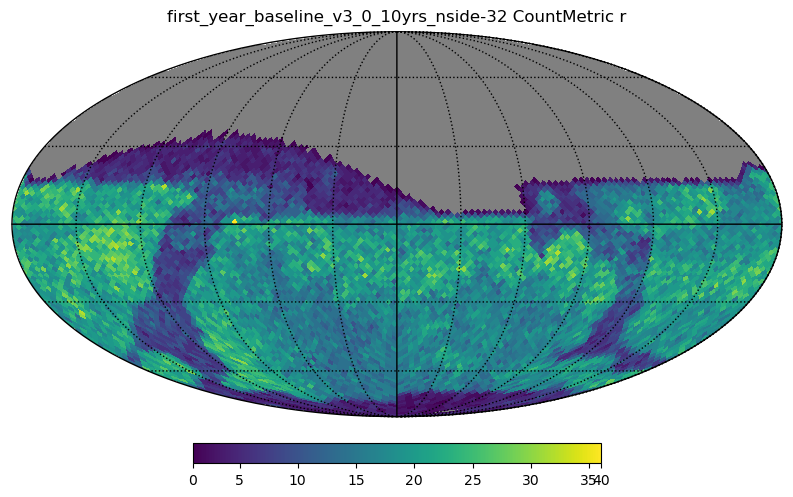

27888.04924307665


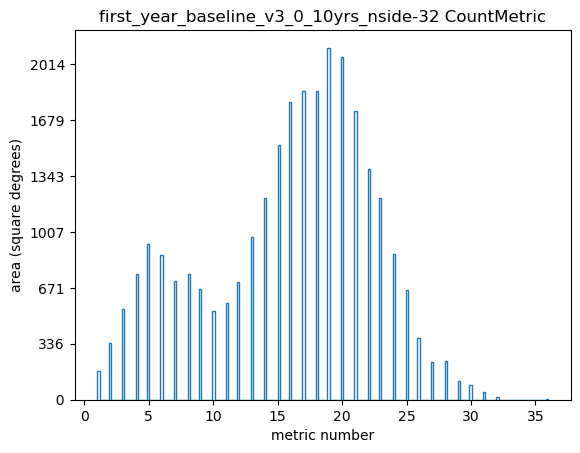

first_year_baseline_v3_0_10yrs_nside-32 CountMetric i
['remove_no_template_results_32_noDD/first_year_baseline_v3_0_10yrs_nside-32_CountMetric_i_and_night_lt_365_and_note_not_like_DD_HEAL.npz']
1
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
[-- -- -- ... 8.0 6.0 9.0] 12288
(12288,)


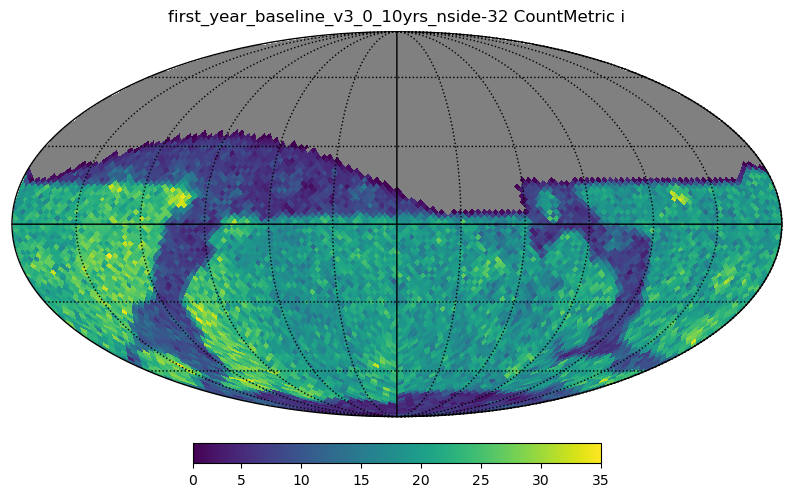

27958.54990927439


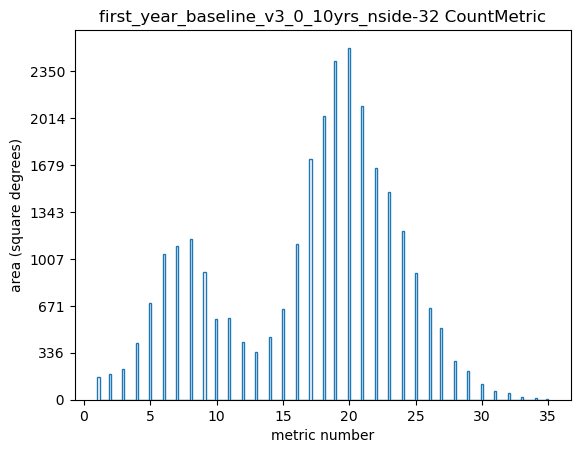

first_year_baseline_v3_0_10yrs_nside-32 CountMetric z
['remove_no_template_results_32_noDD/first_year_baseline_v3_0_10yrs_nside-32_CountMetric_z_and_night_lt_365_and_note_not_like_DD_HEAL.npz']
1
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
[-- -- -- ... 5.0 5.0 4.0] 12288
(12288,)


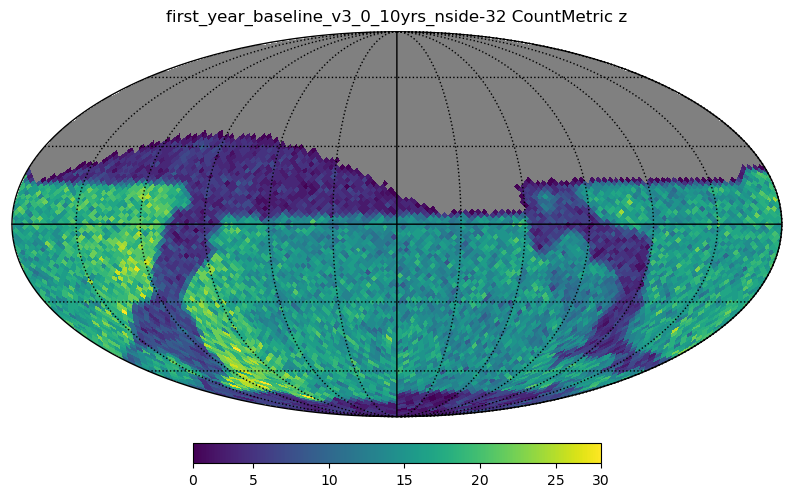

27867.906195591582


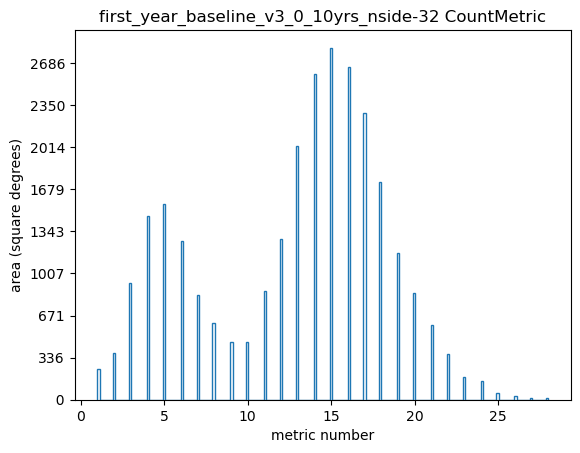

first_year_baseline_v3_0_10yrs_nside-32 CountMetric y
['remove_no_template_results_32_noDD/first_year_baseline_v3_0_10yrs_nside-32_CountMetric_y_and_night_lt_365_and_note_not_like_DD_HEAL.npz']
1
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
[-- -- -- ... 6.0 6.0 3.0] 12288
(12288,)


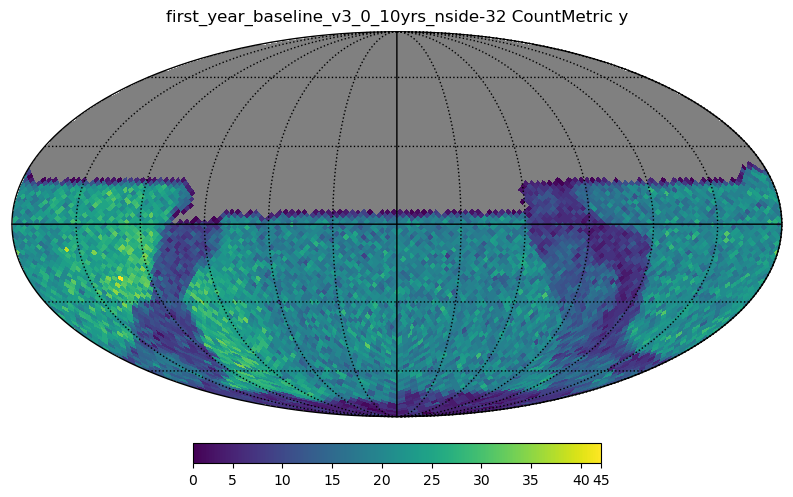

24900.163866124894


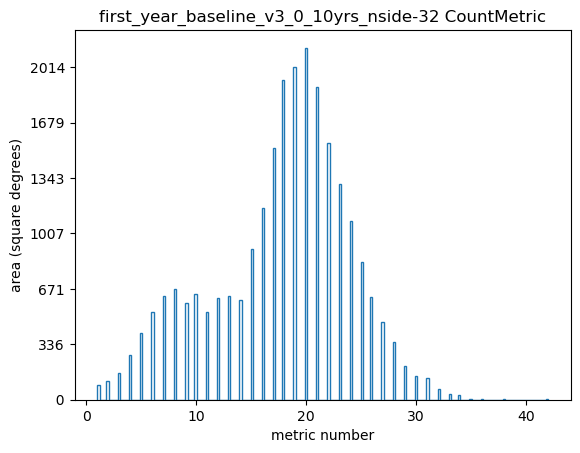

In [14]:
m = "CountMetric"

for filt in ["all","u","g","r","i","z","y"]:
    
    pix_area = hp.pixelfunc.nside2pixarea(nside, degrees=True) # square degrees

    _runName = "{}_nside-{}".format(runName,nside).replace(".","_")
    print(_runName,m,filt)
    metric_plot = load_template_metric(_runName,
                                       metric=m,
                                       filt=filt, print_flag=True,
                                      save_dir = save_dir)
    print(metric_plot.shape)

    title = "{} {} {}".format(_runName,m,filt)
    skymap_plot(metric_plot, title = title)
    histogram_plot(metric_plot,bins = 200,title=title,pix_area=pix_area)

first_year_baseline_v3_0_10yrs_nside-32 PairMetric all
['remove_no_template_results_32_noDD/first_year_baseline_v3_0_10yrs_nside-32_PairMetric_night_lt_365_and_note_not_like_DD_HEAL.npz']
1
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
[-- -- -- ... 12.0 9.0 8.0] 12288
(12288,)


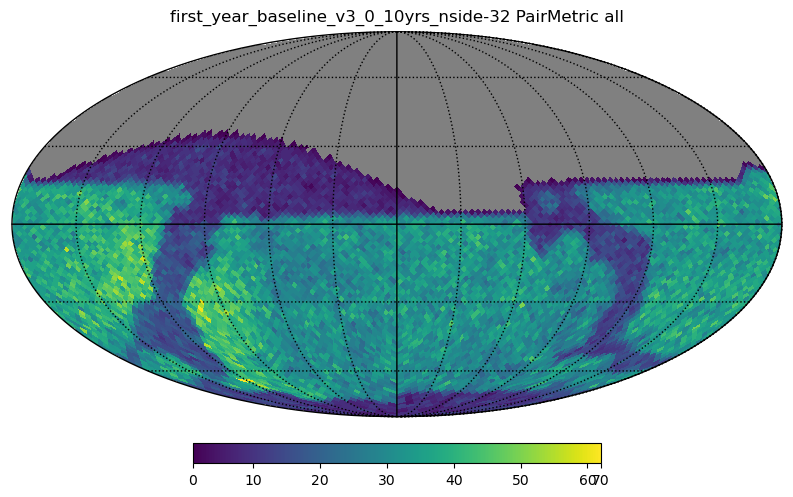

27961.907083855232


/tmp/ipykernel_84095/2638790992.py:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_yticklabels(['{:3.0f}'.format(x * pix_area) for x in y_vals])


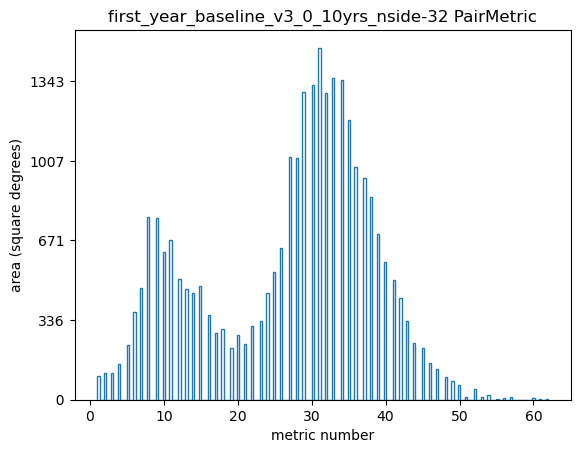

first_year_baseline_v3_0_10yrs_nside-32 PairMetric r_or_g
['remove_no_template_results_32_noDD/first_year_baseline_v3_0_10yrs_nside-32_PairMetric_r_or_g_and_night_lt_365_and_note_not_like_DD_HEAL.npz']
1
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
[-- -- -- ... -- -- 1.0] 12288
(12288,)


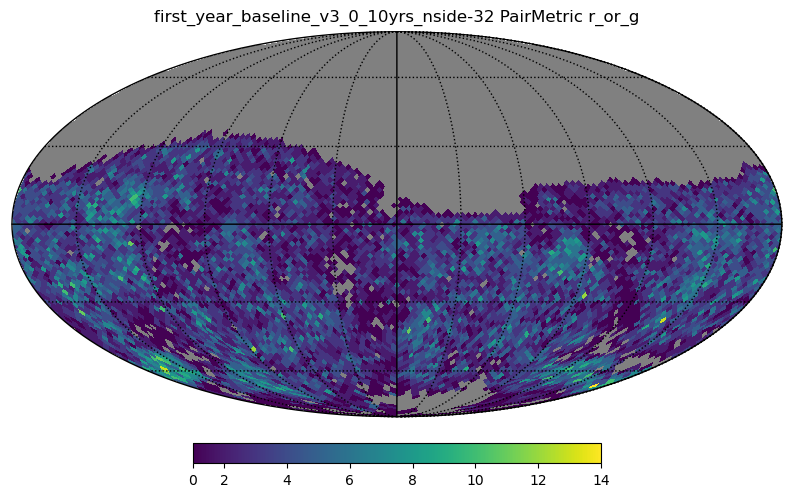

26320.24871382219


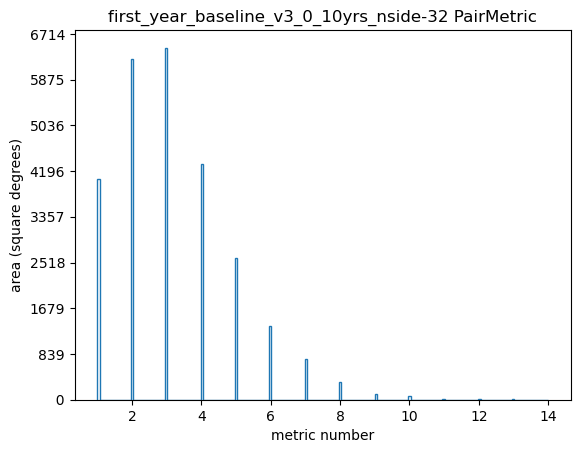

first_year_baseline_v3_0_10yrs_nside-32 PairMetric r_or_i
['remove_no_template_results_32_noDD/first_year_baseline_v3_0_10yrs_nside-32_PairMetric_r_or_i_and_night_lt_365_and_note_not_like_DD_HEAL.npz']
1
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
[-- -- -- ... 3.0 2.0 3.0] 12288
(12288,)


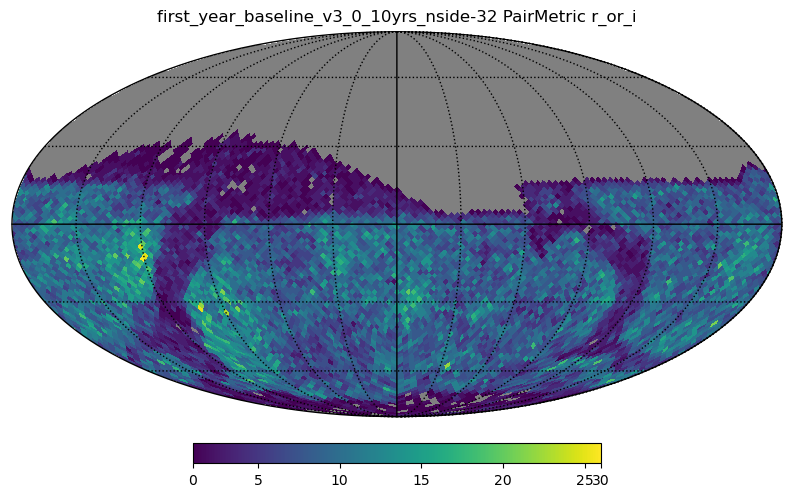

27461.688071309378


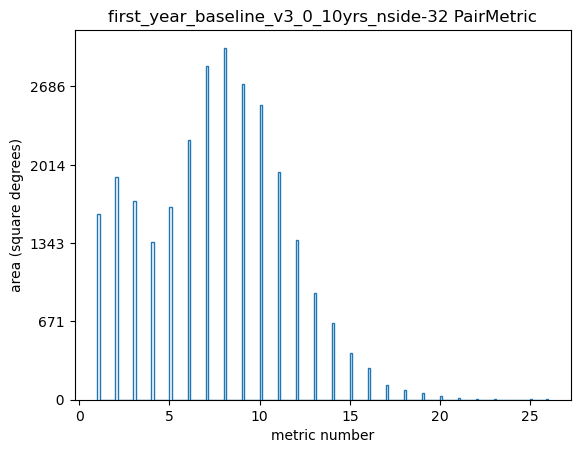

first_year_baseline_v3_0_10yrs_nside-32 PairMetric r_or_z
['remove_no_template_results_32_noDD/first_year_baseline_v3_0_10yrs_nside-32_PairMetric_r_or_z_and_night_lt_365_and_note_not_like_DD_HEAL.npz']
1
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
[-- -- -- ... -- -- --] 12288
(12288,)


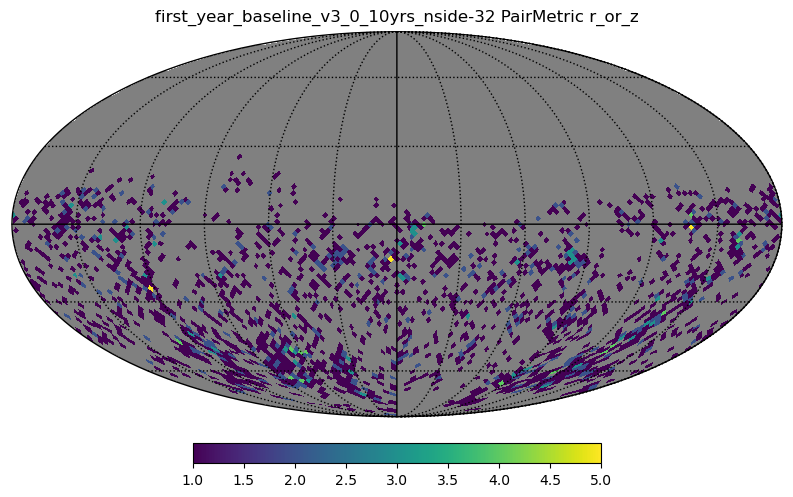

6791.564177048762


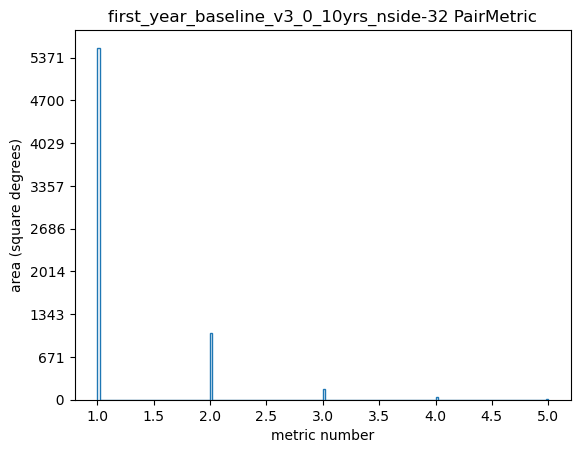

In [15]:
m = "PairMetric"

for filt in ["all","r_or_g","r_or_i","r_or_z"]:
    pix_area = hp.pixelfunc.nside2pixarea(nside, degrees=True) # square degrees

    _runName = "{}_nside-{}".format(runName,nside).replace(".","_")
    print(_runName,m,filt)
    metric_plot = load_template_metric(_runName,
                                       metric=m,
                                       filt=filt, print_flag=True,
                                      save_dir = save_dir)
    print(metric_plot.shape)

    title = "{} {} {}".format(_runName,m,filt)
    skymap_plot(metric_plot, title = title)
    histogram_plot(metric_plot,bins = 200,title=title,pix_area=pix_area)

In [16]:
### TODO
# double check the area in the pair histogram

first_year_baseline_v3.0_10yrs doAllTemplateMetrics_reduceDeltaNight r
14
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
Healpix slicer

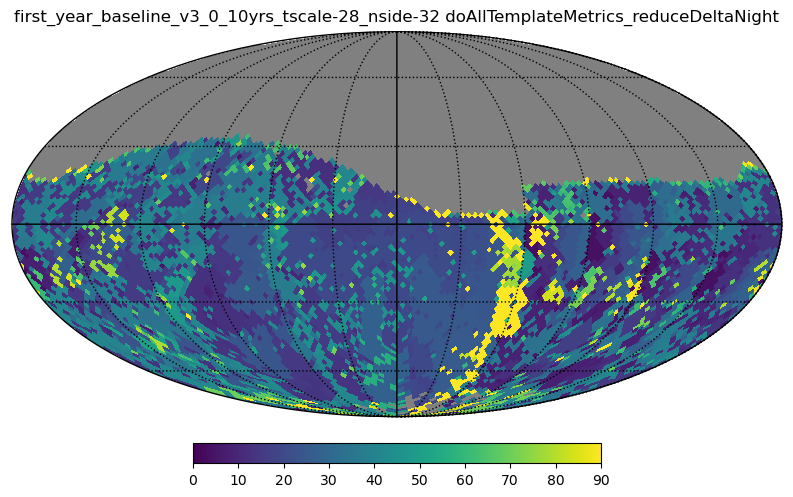

27367.687183045728


/tmp/ipykernel_84095/2638790992.py:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_yticklabels(['{:3.0f}'.format(x * pix_area) for x in y_vals])


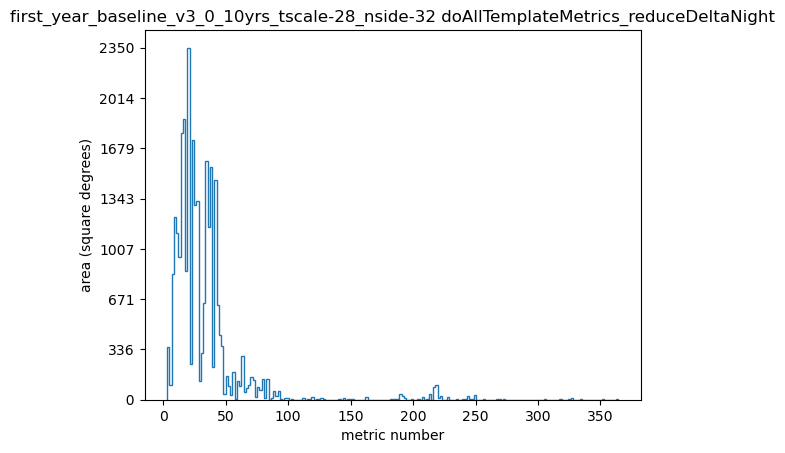

In [17]:
# m = "doAllTemplateMetrics_Night"
m = "doAllTemplateMetrics_reduceDeltaNight" # add a vline at the template timescale to see if it peaks
filt = "r"

for tscale in tscales:
    
    # divide year 1 into chunks of a given template_timescale
    template_nights = np.arange(0,365+tscale,tscale)
    template_nights[-1] = 365 # consider only the first year
        
    _runName = "{}_tscale-{}_nside-{}".format(runName,tscale,nside).replace(".","_")
    print(runName,m,filt)
    metric_plot = load_template_metric(_runName,
                                       metric=m,
                                       filt=filt,
                                       operation="min",save_dir = save_dir)
    print(metric_plot.shape)
    
    title = "{} {}".format(_runName,m)
    
#     skymap_plot_Night(metric_plot, title = title, template_nights = template_nights,
#                       _min = 0, _max = 365)
    skymap_plot_Night(metric_plot, title = title, template_nights = template_nights,
                      _min = 0, _max = 90)
    histogram_plot(metric_plot,bins = 200,title=title,pix_area=pix_area)
    
#     break

In [18]:
metric_plot

masked_array(data=[--, --, --, ..., 70.0, 182.0, 187.0],
             mask=[ True,  True,  True, ..., False, False, False],
       fill_value=nan)

first_year_baseline_v3.0_10yrs doPairTemplateMetrics_reducePairs all
14
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
Healpix slicer u

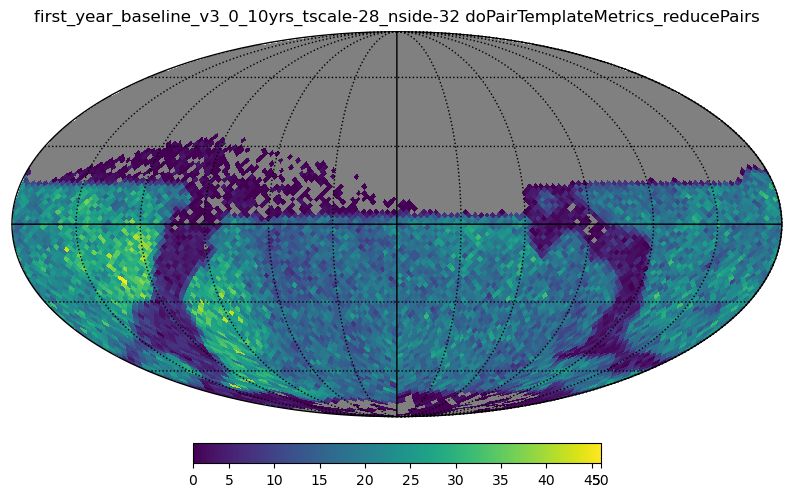

25870.387319989004


/tmp/ipykernel_84095/2638790992.py:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_yticklabels(['{:3.0f}'.format(x * pix_area) for x in y_vals])


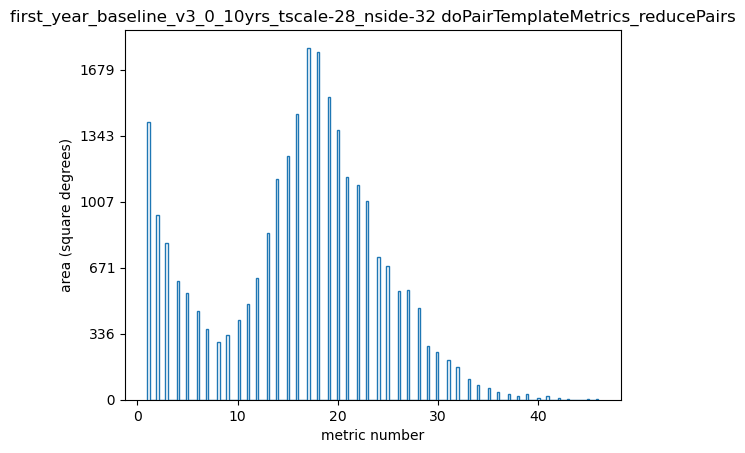

In [19]:
m = "doPairTemplateMetrics_reducePairs"
filt = "all"
# filt = "r_or_g"
pix_area = hp.pixelfunc.nside2pixarea(nside, degrees=True) # square degrees

for tscale in tscales:
        
    _runName = "{}_tscale-{}_nside-{}".format(runName,tscale,nside).replace(".","_")
    print(runName,m,filt)
    metric_plot = load_template_metric(_runName,
                                       metric=m,
                                       filt=filt,save_dir = save_dir)
    print(metric_plot.shape)
    
    title = "{} {}".format(_runName,m)
    skymap_plot(metric_plot, title = title)
    histogram_plot(metric_plot,bins=200,title=title,pix_area=pix_area)
        
#     break

first_year_baseline_v3.0_10yrs doAllTemplateMetrics_reduceCount all
14
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
Healpix slicer us

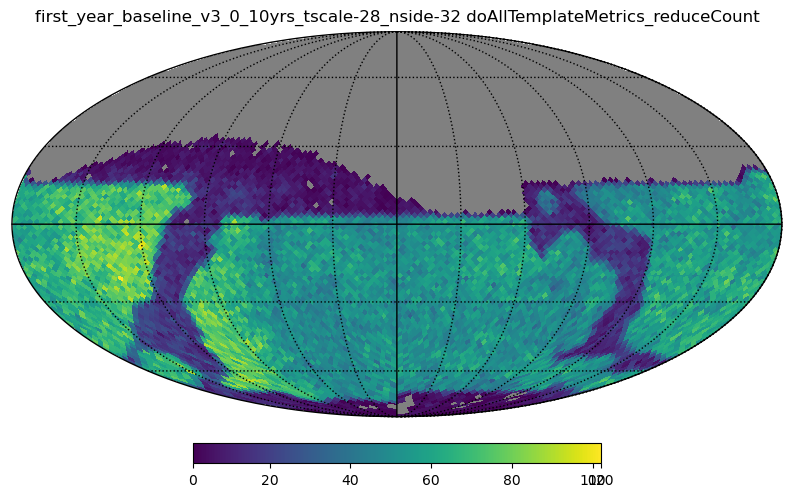

27371.04435762657


/tmp/ipykernel_84095/2638790992.py:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_yticklabels(['{:3.0f}'.format(x * pix_area) for x in y_vals])


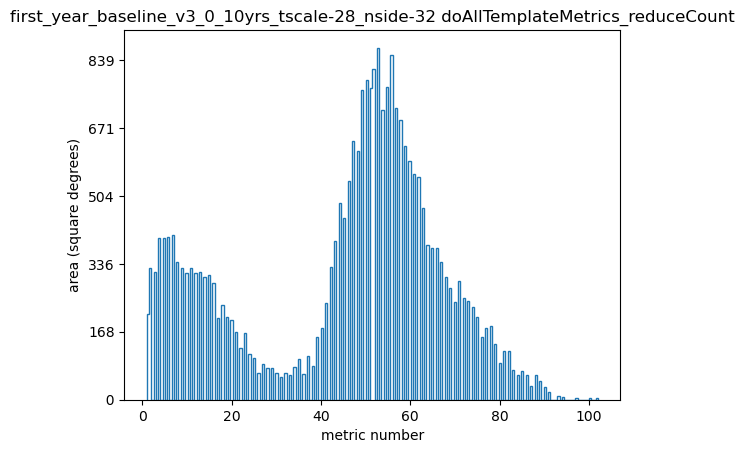

In [20]:
m = "doAllTemplateMetrics_reduceCount"
filt = "all"
pix_area = hp.pixelfunc.nside2pixarea(nside, degrees=True) # square degrees

for tscale in tscales:
        
    _runName = "{}_tscale-{}_nside-{}".format(runName,tscale,nside).replace(".","_")
    print(runName,m,filt)
    metric_plot = load_template_metric(_runName,
                                       metric=m,
                                       filt=filt,save_dir = save_dir)
    print(metric_plot.shape)
    
    title = "{} {}".format(_runName,m)
    skymap_plot(metric_plot, title = title)
    histogram_plot(metric_plot,bins = 200,title=title,pix_area=pix_area)
        
#     break

first_year_baseline_v3.0_10yrs doAllTemplateMetrics_reduceCount u
14
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
Healpix slicer usin

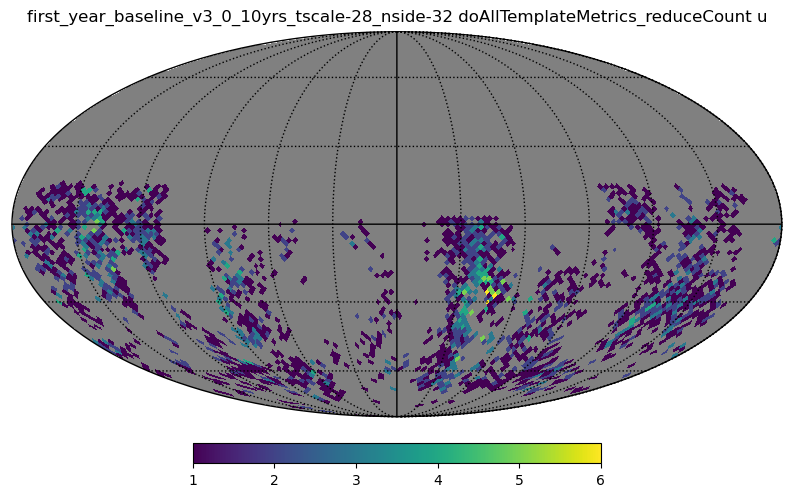

6888.922239893257


/tmp/ipykernel_84095/2638790992.py:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_yticklabels(['{:3.0f}'.format(x * pix_area) for x in y_vals])


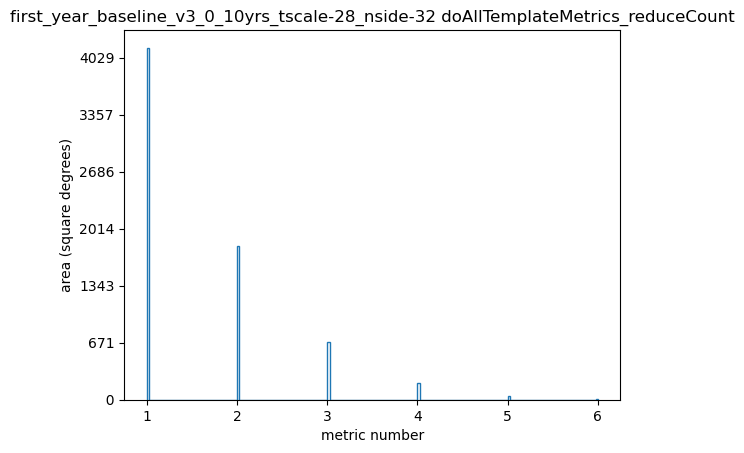

first_year_baseline_v3.0_10yrs doAllTemplateMetrics_reduceCount g
14
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
Healpix slicer usin

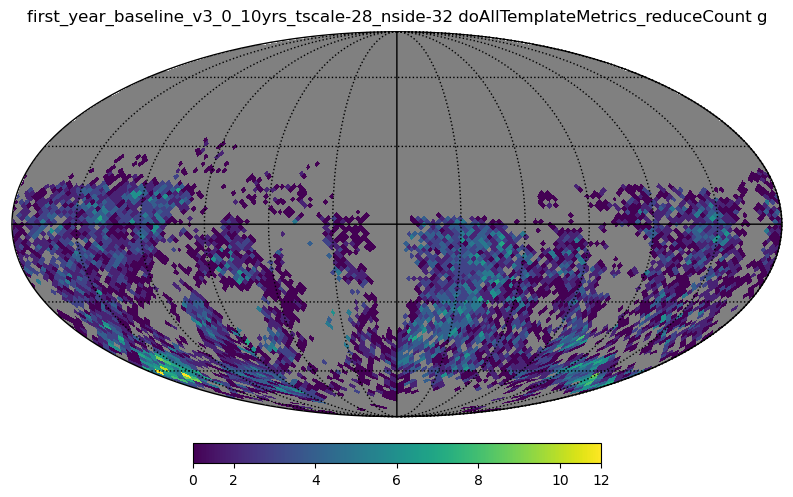

15107.285613801003


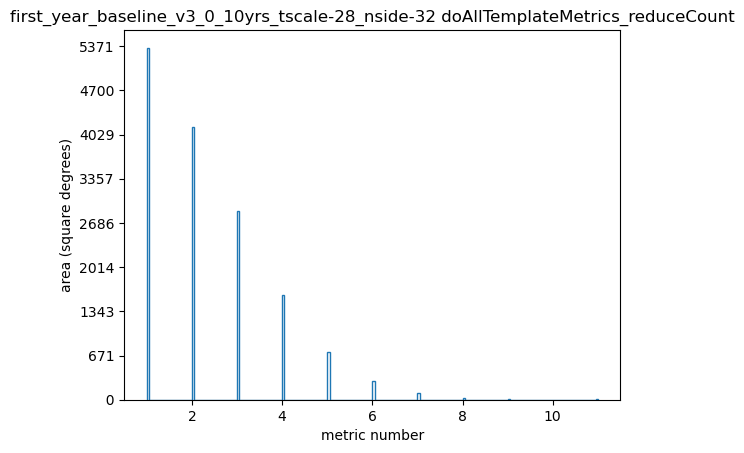

first_year_baseline_v3.0_10yrs doAllTemplateMetrics_reduceCount r
14
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
Healpix slicer usin

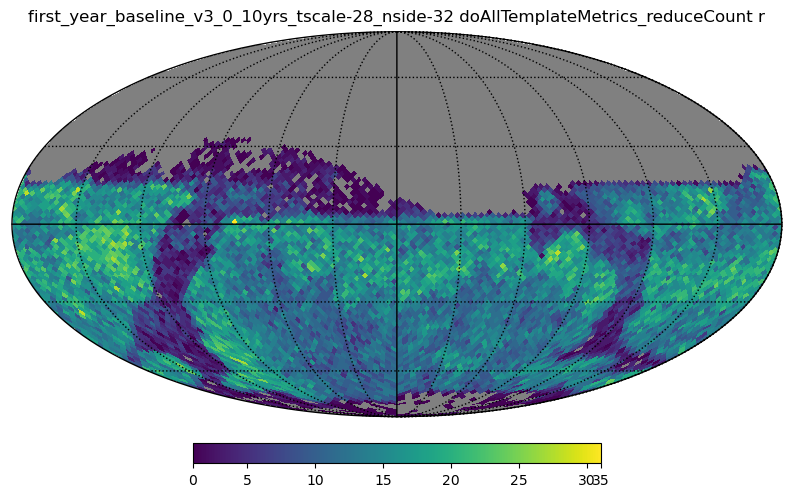

26249.748047624453


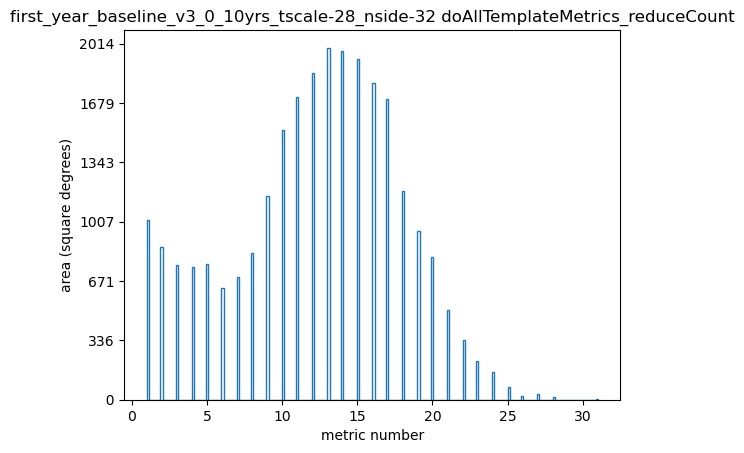

first_year_baseline_v3.0_10yrs doAllTemplateMetrics_reduceCount i
14
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
Healpix slicer usin

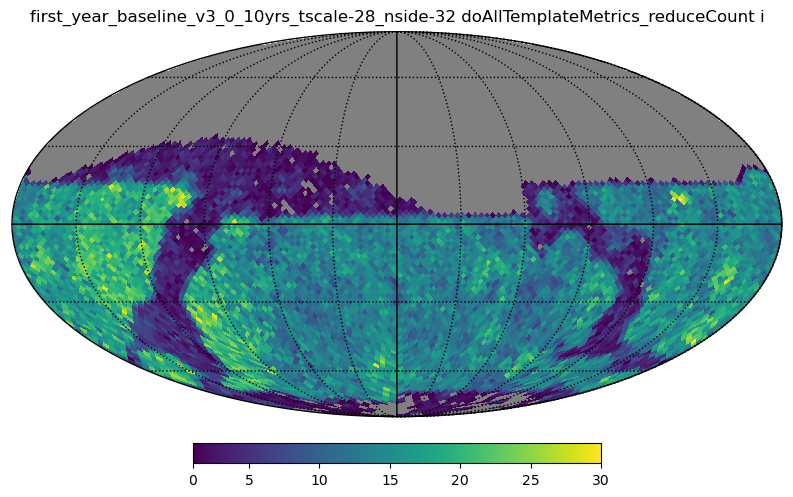

27028.612550380414


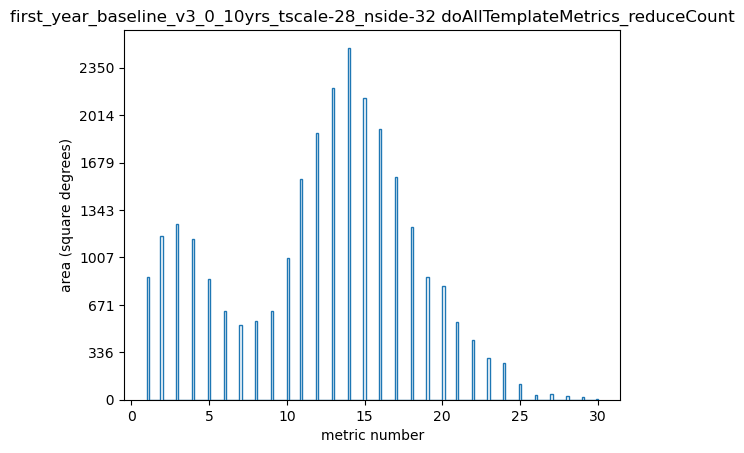

first_year_baseline_v3.0_10yrs doAllTemplateMetrics_reduceCount z
14
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
Healpix slicer usin

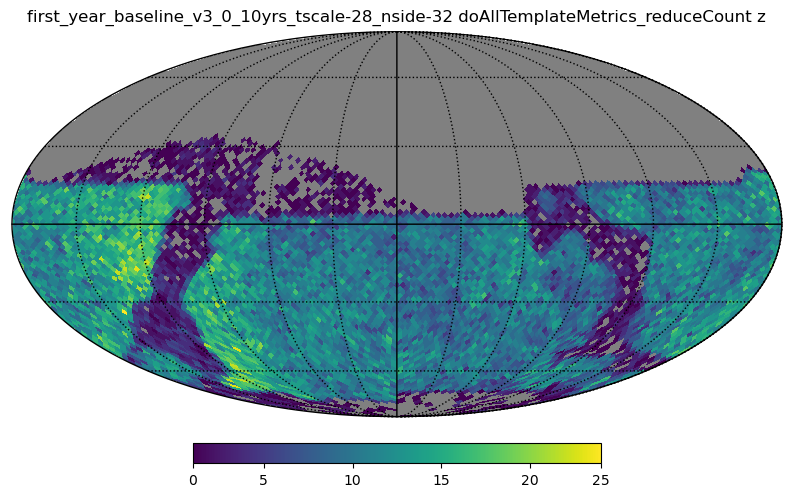

25450.74049738342


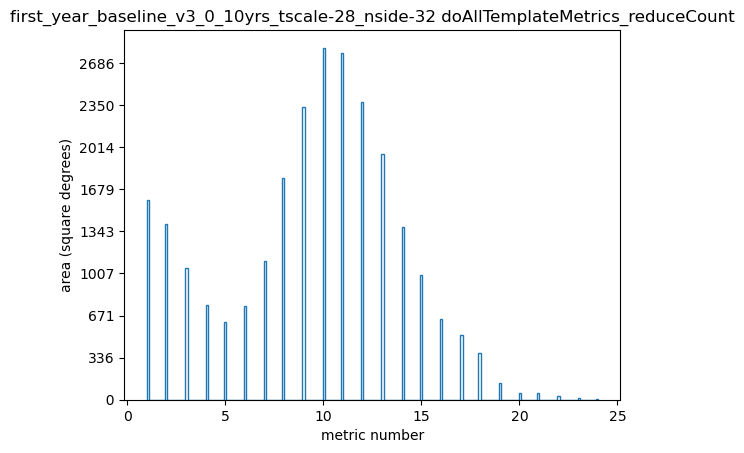

first_year_baseline_v3.0_10yrs doAllTemplateMetrics_reduceCount y
14
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
Healpix slicer usin

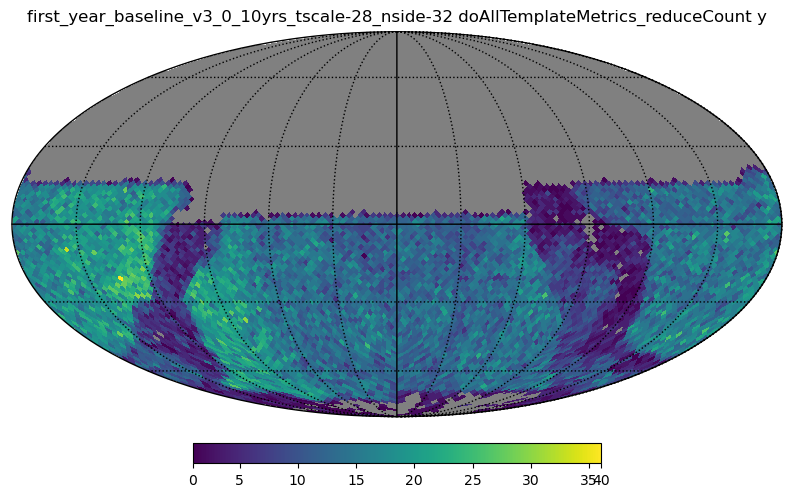

24070.941744656262


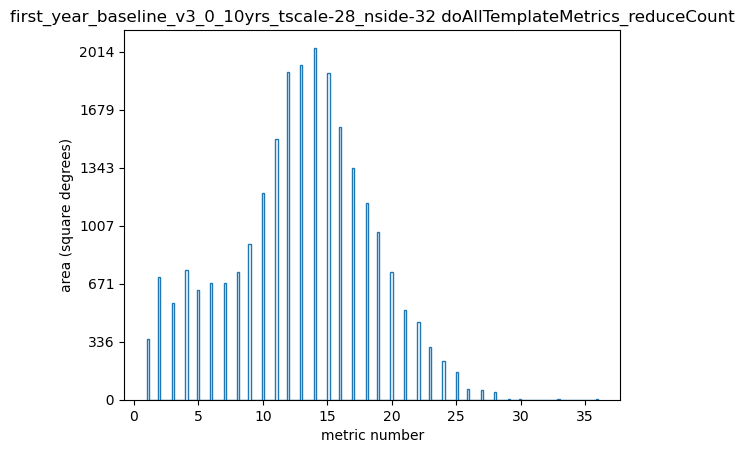

In [21]:
m = "doAllTemplateMetrics_reduceCount"
filters = ["u","g","r","i","z","y"]
tscale = 28
pix_area = hp.pixelfunc.nside2pixarea(nside, degrees=True) # square degrees

for filt in filters:
        
    _runName = "{}_tscale-{}_nside-{}".format(runName,tscale,nside).replace(".","_")
    print(runName,m,filt)
    metric_plot = load_template_metric(_runName,
                                       metric=m,
                                       filt=filt,save_dir = save_dir)
    print(metric_plot.shape)
    
    title = "{} {} {}".format(_runName,m, filt)
    skymap_plot(metric_plot, title = title)
    histogram_plot(metric_plot,bins = 200,title=title,pix_area=pix_area)
        

In [22]:
# Count up area in footprint from the baseline, for reference (varies by filter)
m = "CountMetric"
_runName = "{}_nside-{}".format(runName,nside).replace(".","_")
pix_area = hp.pixelfunc.nside2pixarea(nside, degrees=True) # square degrees

footprint_area = {}
for filt in 'ugrizy':
    
    print(_runName,m,filt)
    metric_plot = load_template_metric(_runName,
                                       metric=m,
                                       filt=filt, print_flag=True,
                                      save_dir = save_dir)
    print(metric_plot.shape)
    
    x = metric_plot.data
    
    footprint_area[filt] = len(x[x>0]) * pix_area    

first_year_baseline_v3_0_10yrs_nside-32 CountMetric u
['remove_no_template_results_32_noDD/first_year_baseline_v3_0_10yrs_nside-32_CountMetric_u_and_night_lt_365_and_note_not_like_DD_HEAL.npz']
1
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
[-- -- -- ... 4.0 2.0 1.0] 12288
(12288,)
first_year_baseline_v3_0_10yrs_nside-32 CountMetric g
['remove_no_template_results_32_noDD/first_year_baseline_v3_0_10yrs_nside-32_CountMetric_g_and_night_lt_365_and_note_not_like_DD_HEAL.npz']
1
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
[-- -- -- ... 3.0 2.0 2.0] 12288
(12288,)
first_year_baseline_v3_0_10yrs_nside-32 CountMetric r
['remove_no_template_results_32_noDD/first_year_baseline_v3_0_10yrs_nside-32_CountMetric_r_and_night_lt_365_and_note_not_like_DD_HEAL.npz']
1
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
[-- -- -- ... 4.0 4.0 5.0] 12288
(12288,)
first_year_baseline_v3_0_10yrs_nside-32 CountMetric i
['re

In [23]:
footprint_area

{'u': 24446.945297710867,
 'g': 27485.18829337529,
 'r': 27888.04924307665,
 'i': 27958.54990927439,
 'z': 27867.906195591582,
 'y': 24900.163866124894}

In [24]:
m = "doAllTemplateMetrics_reduceCount"
pix_area = hp.pixelfunc.nside2pixarea(nside, degrees=True) # square degrees

area_Count = {}

for tscale in tscales:
    
    template_nights = template_timescales[str(tscale)]
    print(template_nights)
    
    area_Count[str(tscale)] = {}
    
    for filt in 'ugrizy':
#     for filt in 'grizy':
        
        visit_area = []

        for t in template_nights[1:]:
        
            _runName = "{}_tscale-{}_nside-{}".format(runName,tscale,nside).replace(".","_")
            print(runName,m,filt, t)
            metric_plot = load_template_metric(_runName,
                                               metric=m,
                                               filt=filt,
                                               time = t,
                                               save_dir = save_dir,
                                              print_flag = True)
            
            # there may be missing metric files (e.g. no observations of u with t<7d)
            if metric_plot is None:
                visit_area.append(0)
                continue
                
            print(metric_plot.shape)
            
            x = metric_plot.data
            area = len(x[x>0]) * pix_area
            
            visit_area.append(area)
            print(area)    
            
        visit_area = np.array(visit_area)
        
        area_Count[str(tscale)][filt] = visit_area
#         break


[  0  28  56  84 112 140 168 196 224 252 280 308 336 364 365]
first_year_baseline_v3.0_10yrs doAllTemplateMetrics_reduceCount u 28
['remove_no_template_results_32_noDD/first_year_baseline_v3_0_10yrs_tscale-28_nside-32_doAllTemplateMetrics_reduceCount_u_and_night_lt_28_and_note_not_like_DD_HEAL.npz']
1
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
[-- -- -- ... -- -- --] 12288
(12288,)
0.0
first_year_baseline_v3.0_10yrs doAllTemplateMetrics_reduceCount u 56
['remove_no_template_results_32_noDD/first_year_baseline_v3_0_10yrs_tscale-28_nside-32_doAllTemplateMetrics_reduceCount_u_and_night_lt_56_and_note_not_like_DD_HEAL.npz']
1
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
[-- -- -- ... -- -- --] 12288
(12288,)
43.643269550980676
first_year_baseline_v3.0_10yrs doAllTemplateMetrics_reduceCount u 84
['remove_no_template_results_32_noDD/first_year_baseline_v3_0_10yrs_tscale-28_nside-32_doAllTemplateMetrics_reduceCount_u_and_night_lt

Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
[-- -- -- ... -- -- --] 12288
(12288,)
1655.0870683564208
first_year_baseline_v3.0_10yrs doAllTemplateMetrics_reduceCount g 308
['remove_no_template_results_32_noDD/first_year_baseline_v3_0_10yrs_tscale-28_nside-32_doAllTemplateMetrics_reduceCount_g_and_night_lt_308_and_note_not_like_DD_HEAL.npz']
1
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
[-- -- -- ... -- -- --] 12288
(12288,)
1258.9404678167502
first_year_baseline_v3.0_10yrs doAllTemplateMetrics_reduceCount g 336
['remove_no_template_results_32_noDD/first_year_baseline_v3_0_10yrs_tscale-28_nside-32_doAllTemplateMetrics_reduceCount_g_and_night_lt_336_and_note_not_like_DD_HEAL.npz']
1
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
[-- -- -- ... -- -- --] 12288
(12288,)
2635.382045963064
first_year_baseline_v3.0_10yrs doAllTemplateMetrics_reduceCount g 364
['remove_no_template_results_32_noDD/first_

['remove_no_template_results_32_noDD/first_year_baseline_v3_0_10yrs_tscale-28_nside-32_doAllTemplateMetrics_reduceCount_i_and_night_lt_168_and_note_not_like_DD_HEAL.npz']
1
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
[-- -- -- ... 1.0 1.0 --] 12288
(12288,)
9930.522410138525
first_year_baseline_v3.0_10yrs doAllTemplateMetrics_reduceCount i 196
['remove_no_template_results_32_noDD/first_year_baseline_v3_0_10yrs_tscale-28_nside-32_doAllTemplateMetrics_reduceCount_i_and_night_lt_196_and_note_not_like_DD_HEAL.npz']
1
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
[-- -- -- ... 1.0 2.0 3.0] 12288
(12288,)
10964.532181038683
first_year_baseline_v3.0_10yrs doAllTemplateMetrics_reduceCount i 224
['remove_no_template_results_32_noDD/first_year_baseline_v3_0_10yrs_tscale-28_nside-32_doAllTemplateMetrics_reduceCount_i_and_night_lt_224_and_note_not_like_DD_HEAL.npz']
1
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcm

Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
[-- -- -- ... -- -- --] 12288
(12288,)
6381.988878185713
first_year_baseline_v3.0_10yrs doAllTemplateMetrics_reduceCount y 84
['remove_no_template_results_32_noDD/first_year_baseline_v3_0_10yrs_tscale-28_nside-32_doAllTemplateMetrics_reduceCount_y_and_night_lt_84_and_note_not_like_DD_HEAL.npz']
1
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
[-- -- -- ... -- -- --] 12288
(12288,)
7906.146137889191
first_year_baseline_v3.0_10yrs doAllTemplateMetrics_reduceCount y 112
['remove_no_template_results_32_noDD/first_year_baseline_v3_0_10yrs_tscale-28_nside-32_doAllTemplateMetrics_reduceCount_y_and_night_lt_112_and_note_not_like_DD_HEAL.npz']
1
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
[-- -- -- ... -- -- --] 12288
(12288,)
6338.345608634731
first_year_baseline_v3.0_10yrs doAllTemplateMetrics_reduceCount y 140
['remove_no_template_results_32_noDD/first_year

In [25]:
### u filter failing for 7d timescale? Missing a file?
# There are no u observations with t<7d
### Add a missing metric file exception

28 u 0.30760780005492994
28 g 0.7615732258458533
28 r 4.0038521728662575
28 i 4.232829010566763
28 z 3.6843753764606673
28 y 4.136712956721046


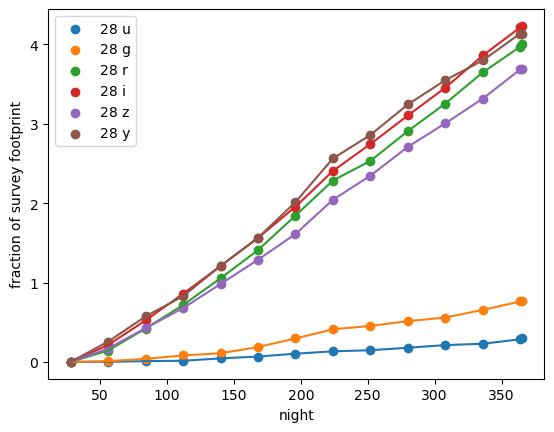

In [26]:
fig = plt.figure()
gs = gridspec.GridSpec(1,1)
ax1 = plt.subplot(gs[0,0])


for tscale in [28]:
    
    template_nights = template_timescales[str(tscale)]
        
    for filt in 'ugrizy':
#     for filt in 'grizy':
        
        visit_area = area_Count[str(tscale)][filt]
        
        cum_visit_area = visit_area.cumsum()
        
        ax1.plot(template_nights[1:],cum_visit_area/footprint_area[filt])
        ax1.scatter(template_nights[1:],cum_visit_area/footprint_area[filt],label = "{} {}".format(tscale,filt))
        
        print(tscale,filt,cum_visit_area[-1]/footprint_area[filt])

ax1.set_xlabel("night")
ax1.set_ylabel("fraction of survey footprint")

ax1.legend()

plt.show()

In [27]:
m = "doAllTemplateMetrics_reduceDeltaNight"
pix_area = hp.pixelfunc.nside2pixarea(nside, degrees=True) # square degrees

area_DeltaNight = {}

for tscale in tscales:
    
    template_nights = template_timescales[str(tscale)]
    print(template_nights)
    
    area_DeltaNight[str(tscale)] = {}
    
    for filt in 'ugrizy':
        
        visit_area = []

        for t in template_nights[1:]:
        
            _runName = "{}_tscale-{}_nside-{}".format(runName,tscale,nside).replace(".","_")
            print(runName,m,filt, t)
            metric_plot = load_template_metric(_runName,
                                               metric=m,
                                               filt=filt,
                                               time = t,
                                               save_dir = save_dir,
                                              print_flag = True)
            
            if metric_plot is None:
                visit_area.append(0)
                continue
                
            print(metric_plot.shape)
            
            x = metric_plot.data
            area = len(x[x>0]) * pix_area
            
            visit_area.append(area)
            print(area)    
            
        visit_area = np.array(visit_area)
        
        area_DeltaNight[str(tscale)][filt] = visit_area
#         break

### This is probably not correct...
# instead just load DeltaNight for all year 1 with minimum operation
# i.e. convert year 1 DeltaNight histogram to a cumulative dist


[  0  28  56  84 112 140 168 196 224 252 280 308 336 364 365]
first_year_baseline_v3.0_10yrs doAllTemplateMetrics_reduceDeltaNight u 28
['remove_no_template_results_32_noDD/first_year_baseline_v3_0_10yrs_tscale-28_nside-32_doAllTemplateMetrics_reduceDeltaNight_u_and_night_lt_28_and_note_not_like_DD_HEAL.npz']
1
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
[-- -- -- ... -- -- --] 12288
(12288,)
0.0
first_year_baseline_v3.0_10yrs doAllTemplateMetrics_reduceDeltaNight u 56
['remove_no_template_results_32_noDD/first_year_baseline_v3_0_10yrs_tscale-28_nside-32_doAllTemplateMetrics_reduceDeltaNight_u_and_night_lt_56_and_note_not_like_DD_HEAL.npz']
1
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
[-- -- -- ... -- -- --] 12288
(12288,)
1265.6548169784396
first_year_baseline_v3.0_10yrs doAllTemplateMetrics_reduceDeltaNight u 84
['remove_no_template_results_32_noDD/first_year_baseline_v3_0_10yrs_tscale-28_nside-32_doAllTemplateMetrics_r

Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
[-- -- -- ... -- -- --] 12288
(12288,)
17027.58947404415
first_year_baseline_v3.0_10yrs doAllTemplateMetrics_reduceDeltaNight g 252
['remove_no_template_results_32_noDD/first_year_baseline_v3_0_10yrs_tscale-28_nside-32_doAllTemplateMetrics_reduceDeltaNight_g_and_night_lt_252_and_note_not_like_DD_HEAL.npz']
1
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
[-- -- -- ... 65.0 -- --] 12288
(12288,)
18887.464191832096
first_year_baseline_v3.0_10yrs doAllTemplateMetrics_reduceDeltaNight g 280
['remove_no_template_results_32_noDD/first_year_baseline_v3_0_10yrs_tscale-28_nside-32_doAllTemplateMetrics_reduceDeltaNight_g_and_night_lt_280_and_note_not_like_DD_HEAL.npz']
1
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
[-- -- -- ... 93.0 -- --] 12288
(12288,)
19669.685869168905
first_year_baseline_v3.0_10yrs doAllTemplateMetrics_reduceDeltaNight g 308
['remove_no_te

['remove_no_template_results_32_noDD/first_year_baseline_v3_0_10yrs_tscale-28_nside-32_doAllTemplateMetrics_reduceDeltaNight_i_and_night_lt_84_and_note_not_like_DD_HEAL.npz']
1
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
[-- -- -- ... -- -- 55.0] 12288
(12288,)
11562.109256429034
first_year_baseline_v3.0_10yrs doAllTemplateMetrics_reduceDeltaNight i 112
['remove_no_template_results_32_noDD/first_year_baseline_v3_0_10yrs_tscale-28_nside-32_doAllTemplateMetrics_reduceDeltaNight_i_and_night_lt_112_and_note_not_like_DD_HEAL.npz']
1
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
[-- -- -- ... 56.0 -- 83.0] 12288
(12288,)
15003.213201794817
first_year_baseline_v3.0_10yrs doAllTemplateMetrics_reduceDeltaNight i 140
['remove_no_template_results_32_noDD/first_year_baseline_v3_0_10yrs_tscale-28_nside-32_doAllTemplateMetrics_reduceDeltaNight_i_and_night_lt_140_and_note_not_like_DD_HEAL.npz']
1
Healpix slicer using NSIDE=32, approximate 

[-- -- -- ... 251.0 251.0 251.0] 12288
(12288,)
26313.5343646605
first_year_baseline_v3.0_10yrs doAllTemplateMetrics_reduceDeltaNight z 308
['remove_no_template_results_32_noDD/first_year_baseline_v3_0_10yrs_tscale-28_nside-32_doAllTemplateMetrics_reduceDeltaNight_z_and_night_lt_308_and_note_not_like_DD_HEAL.npz']
1
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
[-- -- -- ... 279.0 279.0 279.0] 12288
(12288,)
26901.039916308317
first_year_baseline_v3.0_10yrs doAllTemplateMetrics_reduceDeltaNight z 336
['remove_no_template_results_32_noDD/first_year_baseline_v3_0_10yrs_tscale-28_nside-32_doAllTemplateMetrics_reduceDeltaNight_z_and_night_lt_336_and_note_not_like_DD_HEAL.npz']
1
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
[-- -- -- ... 307.0 307.0 307.0] 12288
(12288,)
26988.32645541028
first_year_baseline_v3.0_10yrs doAllTemplateMetrics_reduceDeltaNight z 364
['remove_no_template_results_32_noDD/first_year_baseline_v3_0_10yrs_t

In [28]:
area_DeltaNight["28"]

{'u': array([    0.        ,  1265.65481698,  2249.30696917,  3833.89337132,
         5502.409138  ,  7647.64369516,  9165.08660571, 11035.03284724,
        13150.05283317, 14439.20787221, 15808.9351012 , 17175.3051556 ,
        18011.24162623, 19632.75694878]),
 'g': array([    0.        ,  1527.51443428,  3783.53575261,  7100.42423849,
         9819.73564897, 12297.33048963, 14761.49663197, 17027.58947404,
        18887.46419183, 19669.68586917, 21267.70096965, 23141.00438576,
        24265.65787035, 24567.80358262]),
 'r': array([    0.        ,  6308.13103741, 11095.46198969, 14590.28072835,
        17521.09413743, 20519.05103812, 22660.9284207 , 24561.08923346,
        26276.60544427, 26880.89686882, 27119.25626406, 27236.75737439,
        27350.90131014, 27367.68718305]),
 'i': array([    0.        ,  7909.50331247, 11562.10925643, 15003.21320179,
        17843.38289719, 20163.19053255, 22284.92486765, 24168.2998075 ,
        26864.11099592, 27203.18562858, 27485.18829338, 27528.

In [29]:
template_nights, len(template_nights)

(array([  0,  28,  56,  84, 112, 140, 168, 196, 224, 252, 280, 308, 336,
        364, 365]),
 15)

In [30]:
visit_area, len(visit_area)

(array([    0.        ,  9366.51708056, 11552.03773269, 13730.84403565,
        16178.22430509, 18323.45886225, 20250.47707166, 23261.86267067,
        24520.80313849, 24554.3748843 , 24631.58989966, 24675.23316921,
        24688.66186753, 24702.09056586]),
 14)

In [31]:
visit_area.cumsum(), len(visit_area.cumsum())

(array([     0.        ,   9366.51708056,  20918.55481324,  34649.3988489 ,
         50827.62315399,  69151.08201624,  89401.55908789, 112663.42175857,
        137184.22489706, 161738.59978135, 186370.18968101, 211045.42285022,
        235734.08471775, 260436.17528361]),
 14)

28 u 0.8030760780005493
28 g 0.8938561133504336
28 r 0.9813410376790659
28 i 0.9872718539865513
28 z 0.9778339959041079
28 y 0.9920453013347715


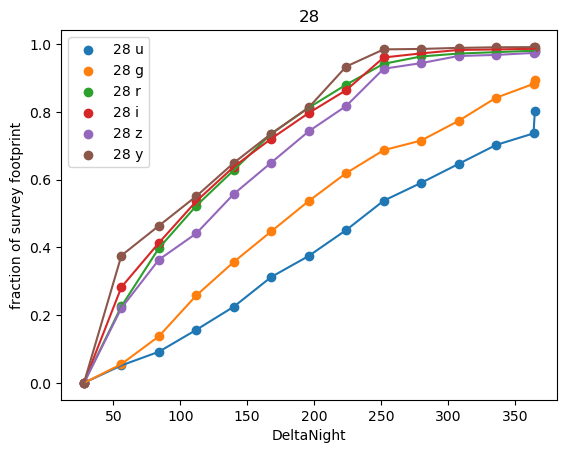

In [32]:
for tscale in tscales:

    fig = plt.figure()
    gs = gridspec.GridSpec(1,1)
    ax1 = plt.subplot(gs[0,0])

    template_nights = template_timescales[str(tscale)]

    for filt in 'ugrizy':

        visit_area = area_DeltaNight[str(tscale)][filt]

        ax1.plot(template_nights[1:],visit_area/footprint_area[filt])
        ax1.scatter(template_nights[1:],visit_area/footprint_area[filt],label = "{} {}".format(tscale,filt))

        print(tscale,filt,visit_area[-1]/footprint_area[filt])

    ax1.set_xlabel("DeltaNight")
    ax1.set_ylabel("fraction of survey footprint")

    ax1.legend()
    plt.title(tscale)

    plt.show()

In [33]:
# the stepped pattern emerges as a result of the template cadence and general survey cadence
# What is the typical revisit timescale of the baseline?
# note that the 28 d timescale, u filter last jump up is due to a very short last time period to get up to 365 d

In [34]:
### need a "first" operation when loading
### check these plots, why does Count need to be cumulative but DeltaNight is regular?
### Why does our z differ so much to Lynne's?

28 u 0.8030760780005493


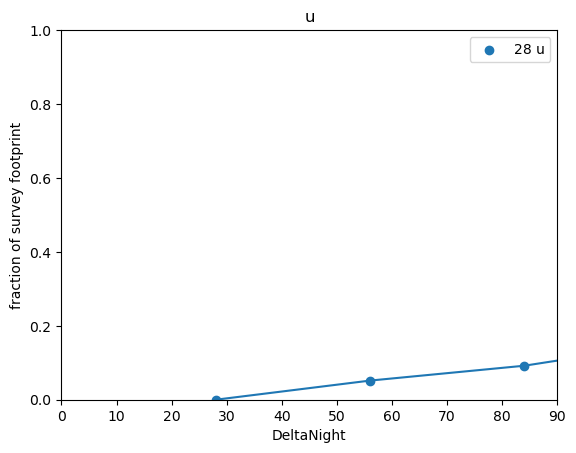

28 g 0.8938561133504336


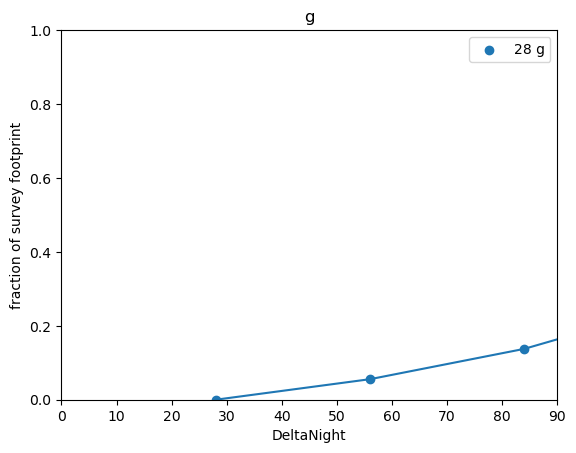

28 r 0.9813410376790659


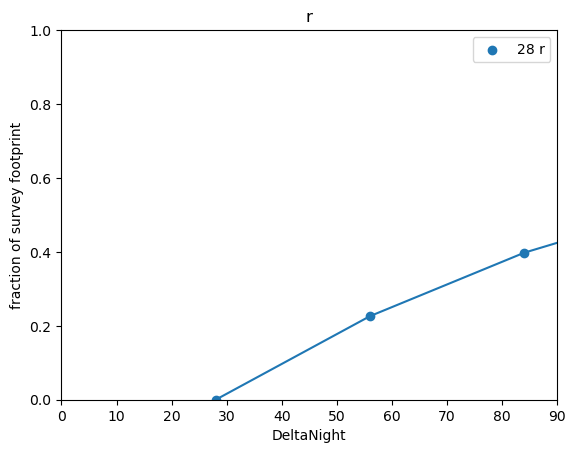

28 i 0.9872718539865513


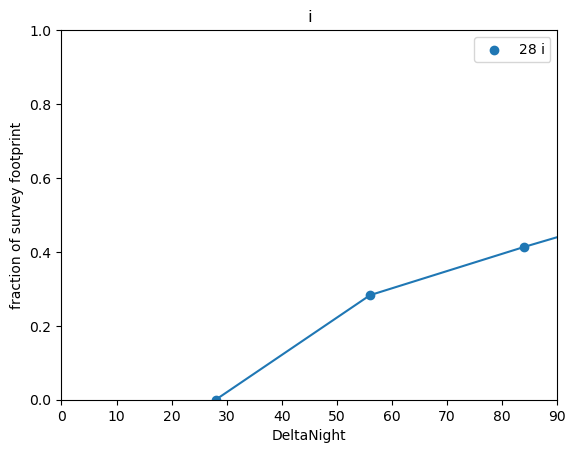

28 z 0.9778339959041079


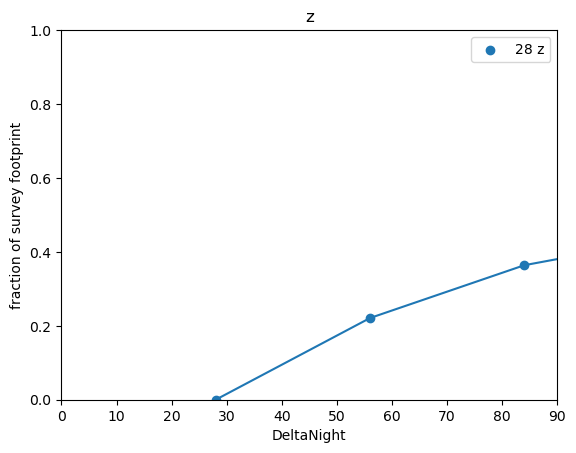

28 y 0.9920453013347715


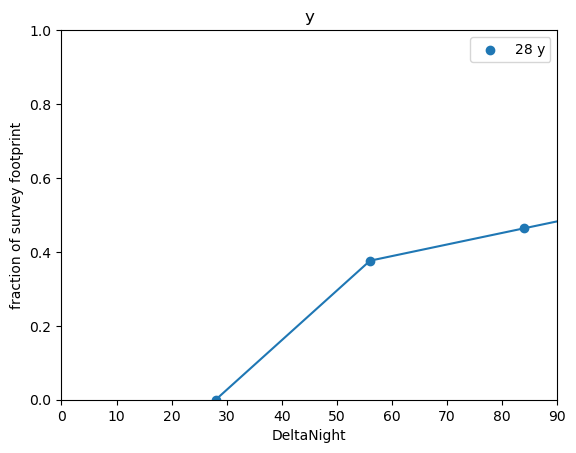

In [35]:
for filt in "ugrizy":
    fig = plt.figure()
    gs = gridspec.GridSpec(1,1)
    ax1 = plt.subplot(gs[0,0])

    for tscale in tscales:

        template_nights = template_timescales[str(tscale)]

        visit_area = area_DeltaNight[str(tscale)][filt]

        ax1.plot(template_nights[1:],visit_area/footprint_area[filt])
        ax1.scatter(template_nights[1:],visit_area/footprint_area[filt],label = "{} {}".format(tscale,filt))

        print(tscale,filt,visit_area[-1]/footprint_area[filt])

    ax1.set_xlabel("DeltaNight")
    ax1.set_ylabel("fraction of survey footprint")

    ax1.legend()
    
    plt.title(filt)
    
    ax1.set_ylim(0,1)
    ax1.set_xlim(0,90)

    plt.show()

In [36]:
filt = "u"
tscale = 28
visit_area = area_DeltaNight[str(tscale)][filt]
visit_area/footprint_area[filt]

array([0.        , 0.05177149, 0.09200769, 0.15682505, 0.22507553,
       0.31282615, 0.37489701, 0.45138698, 0.53790168, 0.59063444,
       0.646663  , 0.70255424, 0.73674815, 0.80307608])

# analyse the visit databases directly

In [37]:
runName

'first_year_baseline_v3.0_10yrs'

In [38]:
# db_fname = "{}/visit_cut_t-168d_nside-32.db".format(save_dir)
db_fname = "remove_no_template_results_256_noDD/visit_cut_t-28d_nside-256.db"
print(db_fname)

conn = sqlite3.connect(db_fname)
df = pd.read_sql('select * from observations;', conn)
conn.close()
    

remove_no_template_results_256_noDD/visit_cut_t-28d_nside-256.db


In [39]:
df

observationId     fieldRA   fieldDec  observationStartMJD  \
0               20633  325.695926 -16.575946         60247.000577   
1               20634  325.939955 -13.531508         60247.001026   
2               20635  323.540123 -11.421007         60247.001477   
3               20636  326.210819 -10.452767         60247.001934   
4               20637  323.885437  -8.313563         60247.002382   
...               ...         ...        ...                  ...   
154457         216373  313.150514 -33.400167         60583.103719   
154458         216374  311.896346 -30.501156         60583.104153   
154459         216375  309.799463 -33.065898         60583.104572   
154460         216376  308.803243 -38.573783         60583.105036   
154461         216377  305.258323 -38.100961         60583.105450   

        flush_by_mjd  visitExposureTime filter   rotSkyPos  rotSkyPos_desired  \
0       60247.008681               30.0      i  213.548560         213.548560   
1       60247.008681               30.0      i  212.060764         212.060764   
2       60247.008681               30.0      i  218.103852         218.103852   
3       60247.008681               30.0      i  210.953442         210.953442   
4       60247.008681               30.0      i  216.137990         216.137990   
...              ...                ...    ...         ...                ...   
154457  60583.135416               30.0      u  263.368952         263.368952   
154458  60583.135416               30.0      u  252.817162         252.817162   
154459  60583.135416               30.0      u  259.748690         259.748690   
154460  60583.135416               30.0      u  274.052901         274.052901   
154461  60583.135416               30.0      u  268.961891         268.961891   

        numExposures  ...       sunRA     sunDec      moonRA    moonDec  \
0                  2  ...  213.658000 -13.509071   48.792850  20.775814   
1                  2  ...  213.658436 -13.509220   48.798765  20.778782   
2                  2  ...  213.658872 -13.509369   48.804684  20.781756   
3                  2  ...  213.659315 -13.509520   48.810675  20.784768   
4                  2  ...  213.659750 -13.509668   48.816559  20.787729   
...              ...  ...         ...        ...         ...        ...   
154457             1  ...  186.502703  -2.810087  160.566853  11.187431   
154458             1  ...  186.503096  -2.810255  160.573656  11.185103   
154459             1  ...  186.503475  -2.810418  160.580235  11.182851   
154460             1  ...  186.503894  -2.810599  160.587504  11.180365   
154461             1  ...  186.504268  -2.810759  160.593989  11.178147   

        moonDistance  solarElong  moonPhase  cummTelAz  scripted_id  \
0          89.626982  106.441401  91.016106  -4.728100            0   
1          88.281112  107.684507  91.012872  -2.605059            0   
2          89.690757  106.132374  91.009637  -9.097133            0   
3          86.902375  108.925101  91.006361  -0.931384            0   
4          88.256938  107.388120  91.003144  -6.499966            0   
...              ...         ...        ...        ...          ...   
154457    146.491284  118.081577  16.306773 -33.962407            0   
154458    147.142910  118.265113  16.303118 -25.645576            0   
154459    144.304980  115.642272  16.299583 -32.787433            0   
154460    140.610661  112.747807  16.295678 -46.392912            0   
154461    138.538296  110.355067  16.292194 -44.238741            0   

        npix_template  
0               174.0  
1               117.0  
2               164.0  
3               151.0  
4               174.0  
...               ...  
154457          176.0  
154458          167.0  
154459          174.0  
154460          124.0  
154461          141.0  

[154462 rows x 45 columns]

In [40]:
pix_area = hp.pixelfunc.nside2pixarea(256, degrees=True) # square degrees
lsst_footprint = 9.6 # square degrees, GET EXACT NUMBER?
n_pix = lsst_footprint/pix_area # number of healpixels within each visit footprint
n_pix

183.01103657392062

In [41]:
df["npix_template"] / n_pix

0         0.950762
1         0.639306
2         0.896121
3         0.825087
4         0.950762
            ...   
154457    0.961691
154458    0.912513
154459    0.950762
154460    0.677555
154461    0.770445
Name: npix_template, Length: 154462, dtype: float64

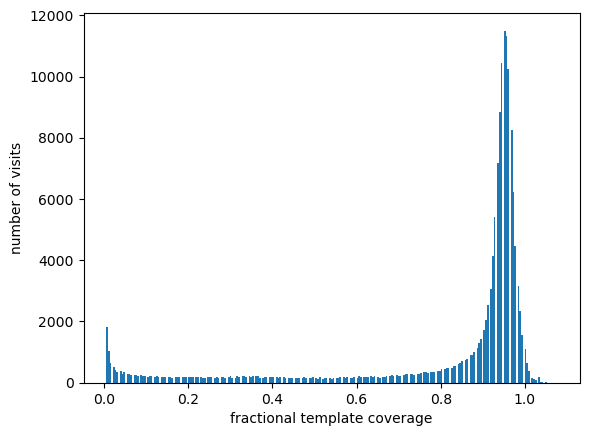

In [42]:
x = df["npix_template"] / n_pix

fig = plt.figure()
gs = gridspec.GridSpec(1,1)
ax1 = plt.subplot(gs[0,0])

ax1.hist(x,bins = "auto")

ax1.set_xlabel("fractional template coverage")
ax1.set_ylabel("number of visits")

plt.show()

In [43]:
len(x[x>=0.9])/len(x)

0.6938858748430035

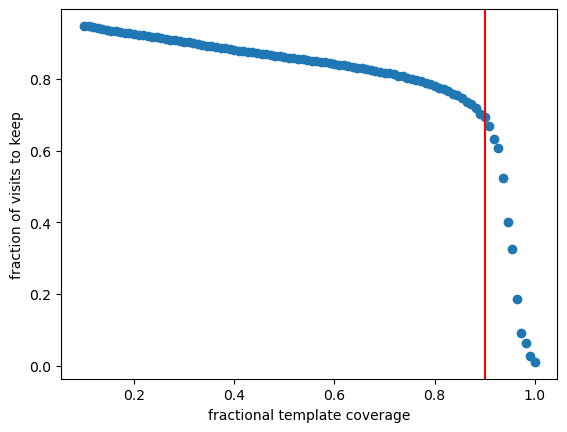

In [44]:
x = df["npix_template"] / n_pix

fig = plt.figure()
gs = gridspec.GridSpec(1,1)
ax1 = plt.subplot(gs[0,0])

keep_list = []
frac_list = np.linspace(0.1,1.0,100)
# print(frac_list)    

for frac in frac_list:
    keep_list.append(len(x[x>=frac])/len(x))
    
ax1.scatter(frac_list,keep_list)

ax1.axvline(0.9,c="r")

ax1.set_xlabel("fractional template coverage")
ax1.set_ylabel("fraction of visits to keep")

plt.show()

In [47]:
keep_list

[0.9482138001579676,
 0.9469189833098108,
 0.9440574380753842,
 0.9414483821263482,
 0.940192409783636,
 0.9376869391824526,
 0.9353627429400111,
 0.9341909336924292,
 0.9318602633657469,
 0.9293159482591188,
 0.9281506130957776,
 0.9256451424945942,
 0.9231655682303738,
 0.9218836995506986,
 0.9194559179604045,
 0.9171964625603708,
 0.9160958682394376,
 0.9136486643964211,
 0.9115122165969624,
 0.9102886146754542,
 0.9080550556123836,
 0.9058862373917209,
 0.9045719982908418,
 0.9021701130375108,
 0.8997099610260129,
 0.8984798850202639,
 0.8956377620385596,
 0.8929704393313566,
 0.8916950447359221,
 0.8889176625966257,
 0.8864380883324053,
 0.8853763385169168,
 0.8829615050951043,
 0.8805660939260141,
 0.8793748624257098,
 0.8772902073001774,
 0.874991907394699,
 0.8740402170113037,
 0.8719620359700121,
 0.8698191140863125,
 0.8687314679338608,
 0.866685657313773,
 0.8644456241664616,
 0.8634939337830664,
 0.8614157527417746,
 0.8594994238065026,
 0.8583729331486061,
 0.8565472413927

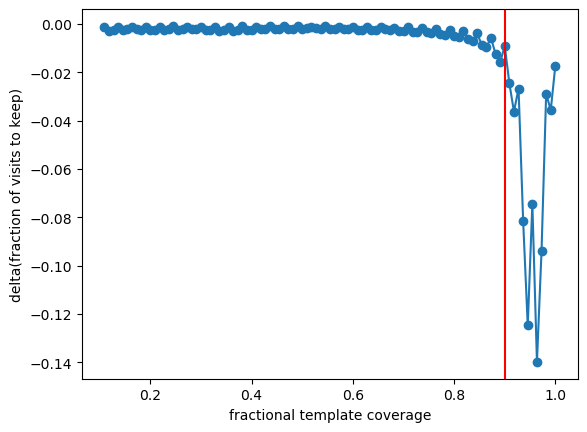

In [48]:
# rate of change in fractional template coverage
# pick optimum value from the turning point?

fig = plt.figure()
gs = gridspec.GridSpec(1,1)
ax1 = plt.subplot(gs[0,0])
    
ax1.scatter(frac_list[1:],np.diff(keep_list))
ax1.plot(frac_list[1:],np.diff(keep_list))

ax1.axvline(0.9,c="r")

ax1.set_xlabel("fractional template coverage")
ax1.set_ylabel("delta(fraction of visits to keep)")

plt.show()

In [46]:
# redact this visit database based on fractional template coverage
# save the redacted db to run "generate_ss" command on